In [211]:
import sys, os
import cv2
import numpy as np
import warnings
import scipy.fftpack
import math
import scipy, scipy.fftpack

# Variables
KERNEL_SIZE = 3

def estimate_watermark(foldername):
    """
    Estimate the watermark from images by calculating the median of gradients.
    Using grad(W) = median(grad(J))
    """
    if not os.path.exists(foldername):
        warnings.warn("Folder does not exist.", UserWarning)
        return None

    images = []
    for root, _, files in os.walk(foldername):
        for file in files:
            img_path = os.path.join(root, file)
            image = cv2.imread(img_path)
            if image is not None:
                images.append(image)
            else:
                print(f'{file} not found.')

    # No images found or readable, exit function
    if not images:
        return None

    # Compute gradients
    print("Computing gradients.")
    gradx = [cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=KERNEL_SIZE) for img in images]
    grady = [cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=KERNEL_SIZE) for img in images]

    # Compute median of gradients
    print("Computing median gradients.")
    Wm_x = np.median(np.array(gradx), axis=0)
    Wm_y = np.median(np.array(grady), axis=0)

    return Wm_x, Wm_y, gradx, grady


def PlotImage(image):
    """ Normalizes an image to the range [0, 1]. """
    im = image.astype(float)
    return (im - np.min(im)) / (np.max(im) - np.min(im))

def poisson_reconstruct2(gradx, grady, boundarysrc):
    """ 
    Reconstructs an image from its gradients using Poisson reconstruction by solving the Poisson equation.
    """
    gyy = grady[1:, :-1] - grady[:-1, :-1]
    gxx = gradx[:-1, 1:] - gradx[:-1, :-1]
    f = np.zeros(boundarysrc.shape)
    f[:-1, 1:] += gxx
    f[1:, :-1] += gyy

    boundary = boundarysrc.copy()
    boundary[1:-1, 1:-1] = 0
    f_bp = (-4 * boundary[1:-1, 1:-1] + boundary[1:-1, 2:] + boundary[1:-1, :-2] +
            boundary[2:, 1:-1] + boundary[:-2, 1:-1])
    f = f[1:-1, 1:-1] - f_bp

    tt = scipy.fftpack.dst(f, norm='ortho')
    fsin = scipy.fftpack.dst(tt.T, norm='ortho').T

    y, x = np.meshgrid(range(1, f.shape[0]+1), range(1, f.shape[1]+1), indexing='ij')
    denom = (2 * np.cos(math.pi * x / (f.shape[1]+2)) - 2) + (2 * np.cos(math.pi * y / (f.shape[0]+2)) - 2)

    f = fsin / denom

    tt = scipy.fftpack.idst(f, norm='ortho')
    img_tt = scipy.fftpack.idst(tt.T, norm='ortho').T

    result = boundary
    result[1:-1, 1:-1] = img_tt
    return result

def poisson_reconstruct(gradx, grady, kernel_size=KERNEL_SIZE, num_iters=100, h=0.1, boundary_image=None, boundary_zero=True):
    """
    Iterative Poisson reconstruction to solve for image using Jacobi relaxation technique.
    """
    ddepth = cv2.CV_64F
    fxx = cv2.Sobel(gradx, ddepth, 1, 0, ksize=kernel_size)
    fyy = cv2.Sobel(grady, ddepth, 0, 1, ksize=kernel_size)
    laplacian = fxx + fyy

    m, n, p = laplacian.shape
    if boundary_zero:
        est = np.zeros_like(laplacian)
    else:
        assert boundary_image is not None and boundary_image.shape == laplacian.shape
        est = boundary_image.copy()

    est[1:-1, 1:-1, :] = np.random.random((m-2, n-2, p))
    loss = []
    for i in range(num_iters):
        old_est = est.copy()
        est[1:-1, 1:-1, :] = 0.25 * (est[:-2, 1:-1, :] + est[1:-1, :-2, :] + est[2:, 1:-1, :] + est[1:-1, 2:, :] - h * h * laplacian[1:-1, 1:-1, :])
        loss.append(np.sum(np.square(est - old_est)))

    return est

def image_threshold(image, threshold=0.5):
    """ 
    Threshold the image to make all its elements greater than threshold*MAX = 1
    """
    im = PlotImage(image)
    im[im >= threshold] = 1
    im[im < 1] = 0
    return im
    
def crop_watermark(gradx, grady, threshold=0.4, boundary_size=2):
    """
    Crops the watermark from gradient images based on edge magnitude thresholding.
    """
    W_mod = np.sqrt(gradx**2 + grady**2)
    W_mod = PlotImage(W_mod)
    
    W_gray = image_threshold(np.mean(W_mod, axis=2), threshold)

    xmin, xmax = np.min(np.where(W_gray == 1)[0]) - boundary_size, np.max(np.where(W_gray == 1)[0]) + boundary_size
    ymin, ymax = np.min(np.where(W_gray == 1)[1]) - boundary_size, np.max(np.where(W_gray == 1)[1]) + boundary_size
    return gradx[xmin:xmax, ymin:ymax, :], grady[xmin:xmax, ymin:ymax, :]

def normalized(img):
    """ Normalizes the image to the range [-1, 1] for operations like correlation and convolution. """
    return 2 * PlotImage(img) - 1

def watermark_detector(img, gx, gy, thresh_low=200, thresh_high=220, printval=False):
    """ Detects a watermark in an image using the Canny edge detector and chamfer matching. """
    Wm = np.mean(np.sqrt(gx**2 + gy**2), axis=2)
    img_edgemap = cv2.Canny(img, thresh_low, thresh_high)
    chamfer_dist = cv2.filter2D(img_edgemap.astype(float), -1, Wm)
    rect = Wm.shape
    index = np.unravel_index(np.argmax(chamfer_dist), img.shape[:-1])
    if printval:
        print(index)
    x, y = index[0] - rect[0] // 2, index[1] - rect[1] // 2
    img_result = img.copy()
    cv2.rectangle(img_result, (y, x), (y + rect[1], x + rect[0]), (255, 0, 0))
    return img_result, (x, y), rect


In [209]:
gx, gy, gxlist, gylist = estimate_watermark('images')


Computing gradients.
Computing median gradients.


(72, 39)
(21, 128)


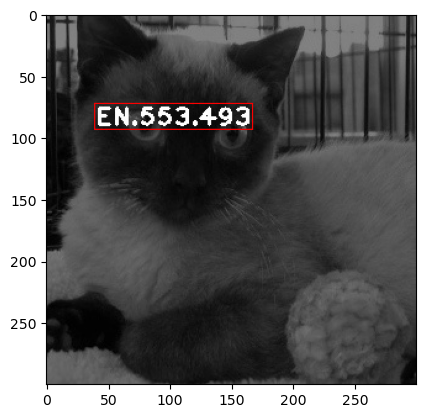

In [210]:

#est = poisson_reconstruct(gx, gy, np.zeros(gx.shape)[:,:,0])
est = poisson_reconstruct(gx, gy)
cropped_gx, cropped_gy = crop_watermark(gx, gy)
W_m = poisson_reconstruct(cropped_gx, cropped_gy)

# random photo
img = cv2.imread('images/cat.1.jpg')
im, start, end = watermark_detector(img, cropped_gx, cropped_gy)
print(start)
print(end)

plt.imshow(im)
plt.show()

In [201]:
kernel_size=KERNEL_SIZE
fxx = cv2.Sobel(gx, cv2.CV_64F, 1, 0, ksize=kernel_size)
fyy = cv2.Sobel(gy, cv2.CV_64F, 0, 1, ksize=kernel_size)
laplacian = fxx + fyy



In [202]:
m,n,p = laplacian.shape

In [204]:
if boundary_zero == True:
    est = np.zeros(laplacian.shape)
else:
    assert(boundary_image is not None)
    assert(boundary_image.shape == laplacian.shape)
    est = boundary_image.copy()
    
    est[1:-1, 1:-1, :] = np.random.random((m-2, n-2, p))
    loss = []

	for i in range(num_iters):
		old_est = est.copy()
		est[1:-1, 1:-1, :] = 0.25*(est[0:-2, 1:-1, :] + est[1:-1, 0:-2, :] + est[2:, 1:-1, :] + est[1:-1, 2:, :] - h*h*laplacian[1:-1, 1:-1, :])
		error = np.sum(np.square(est-old_est))
		loss.append(error)

	return (est)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 3)

In [198]:
est, loss = poisson_reconstruct(gx, gy)

ValueError: too many values to unpack (expected 2)